In [1]:
import numpy as np
import scipy
from numpy import ndarray
from matplotlib import pyplot
from numpy.polynomial.polynomial import Polynomial

import luxpy as lx
from empir19nrm02.MC import WavelengthCalib, ValueCorrection, q_param_org, ValueCorrectionNonLinearity
from empir19nrm02.tools.help import save_fig, label_font_size
from empir19nrm02.tools.draw_values import draw_values_gum
from empir19nrm02.tools.plotting import plotCorrMatrixSmall


E:\TTBV\Python\luxpy\luxpy\spectrum\basics\illuminants.py:512: RankWarning: Polyfit may be poorly conditioned
  xy, pxy, pxT_l7, pxT_L7, l7, L7 = _get_daylightlocus_parameters(ccts, spds, cieobs_)


In [2]:
useLog = False
strLambdaPrime = r'$\lambda^{´}$'
strf1p = r'$f_{1}^{´}$'
outDir = 'Poly'

# ValueCorrection (e.g. correction of non-linearity or wavelength calibration)
## Precondition:
- value pairs $(x',x)$ with the measurement value $x'$ and the reference value $x$
[wavelength calibration] the measurement value is pixel, grating position or the current knowledge about the wavelength scale (the last option is the prefered one) and the reference value is the nominal wavelength
[non-linearity corrections] the reference value is the integration time and the linear relation is calculated using a linear relation between $(0,0)$ and $(t_{\mathrm{ref}}, S_{\mathrm{ref}})$
## Solution
- The points $(x',x)$ will be modeled using a polynomial function $p(x')$ of grade $n$.
- See also ISO/TS 28038:2018. Determination and use of polynomial calibration functions (https://www.iso.org/standard/66349.html )
- $p(x')=\sum_{i=0}^{n}\alpha_{i}x'^{i}$ (without domain scaling)
- The corrected values in the application we will get with $x=p(x')$ or $x-x'=p_diff(x')$

## Sample for a simple wavelength calibration using Hg and Kr Pen Ray lamps

In [3]:
## Sample for a simple wavelength calibration using Hg and Kr Pen Ray lamps
Hg_sd = lx.utils.getdata('..\\data\\SPD\\' + 'Hg.csv', sep=';', kind='np').transpose()
Kr_sd = lx.utils.getdata('..\\data\\SPD\\' + 'Kr.csv', sep=';', kind='np').transpose()


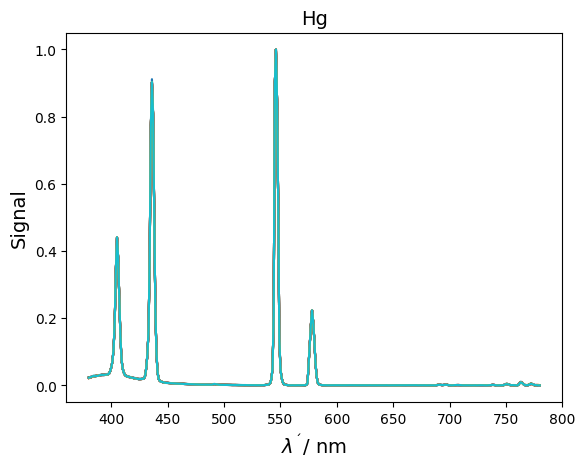

Peak properties: {'peaks_idx': array([ 25,  56, 166], dtype=int64), 'peaks': array([4.0500e+02, 4.3600e+02, 5.4600e+02]), 'heights': array([2.2717e-01, 4.7161e-01, 5.1741e-01]), 'fwhms': array([4.0334e+00, 4.0233e+00, 3.6788e+00]), 'fwhms_mid': array([4.0527e+02, 4.3621e+02, 5.4626e+02]), 'fwhms_mid_heights': array([2.1884e-01, 4.6109e-01, 4.9696e-01])}


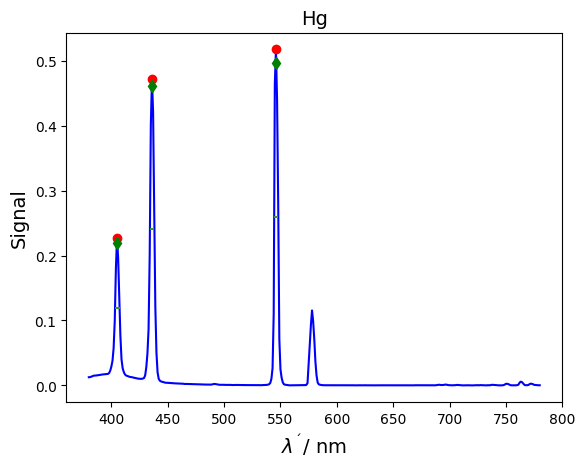

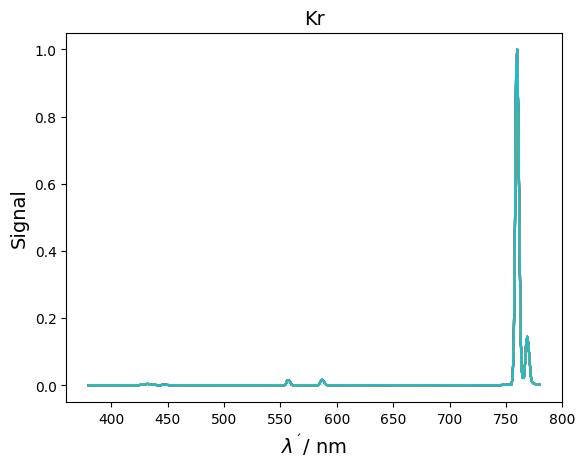

Peak properties: {'peaks_idx': array([177, 207, 380, 389], dtype=int64), 'peaks': array([5.5700e+02, 5.8700e+02, 7.6000e+02, 7.6900e+02]), 'heights': array([1.0829e-02, 1.1389e-02, 6.8112e-01, 9.8717e-02]), 'fwhms': array([3.6623e+00, 3.8931e+00, 3.8112e+00, 3.5336e+00]), 'fwhms_mid': array([5.5703e+02, 5.8715e+02, 7.6000e+02, 7.6906e+02]), 'fwhms_mid_heights': array([1.0779e-02, 1.1106e-02, 6.8094e-01, 9.7818e-02])}


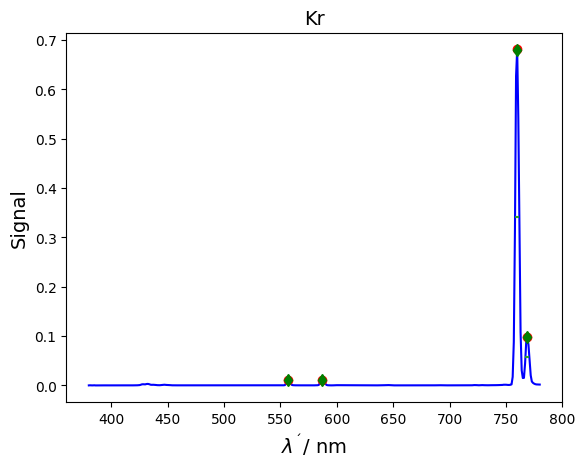

[[4.0466e+02 4.3583e+02 5.4607e+02 5.5703e+02 5.8709e+02 7.6015e+02
  7.6945e+02]
 [4.0527e+02 4.3621e+02 5.4626e+02 5.5703e+02 5.8715e+02 7.6000e+02
  7.6906e+02]]
DomainNone
Org: -18.42963314 + 1.09323518 x - 0.00015735 x**2 + (8.81696415e-08) x**3
mapparam: (0.0, 1.0)
Convert: -18.42963314 + 1.09323518 x - 0.00015735 x**2 + (8.81696415e-08) x**3
DomainRange
Org: 579.91735494 + 199.93811234 x - 0.15737303 x**2 + 0.70535713 x**3
mapparam: (-2.9, 0.005)
Convert: -18.42963314 + 1.09323518 x - 0.00015735 x**2 + (8.81696415e-08) x**3


In [4]:
calib_Hg = WavelengthCalib(type='Hg')
calib_Kr = WavelengthCalib(type='Kr')
# put all peaks together
S = np.hstack((calib_Hg.getPairs(Hg_sd), calib_Kr.getPairs(Kr_sd)))
print( S)

# Model the wavelength function
vc = ValueCorrection(n=3, domain=None)
seriesDomainNone = vc.fit(S[1], S[0], domain=[-1,1])
seriesDomainRange = vc.fit(S[1], S[0], domain=[380,780])
series = seriesDomainRange

print('DomainNone')
print('Org:', seriesDomainNone)
print('mapparam:', seriesDomainNone.mapparms())
print('Convert:', seriesDomainNone.convert())

print('DomainRange')
print('Org:', seriesDomainRange)
print('mapparam:', seriesDomainRange.mapparms())
print('Convert:', seriesDomainRange.convert())


### Showing the result of the wavelength calibration

[-6.1670e-01 -3.7874e-01 -1.8620e-01 2.8725e-03 -5.5240e-02 1.5328e-01
 3.9874e-01] 0.3111133804227753 0.6167023024717082
[2.3148e-03 2.8640e-03 -1.0613e-01 8.1554e-02 2.9785e-02 -9.5121e-02
 8.4727e-02] 0.07075207209340983 0.10612516443711684


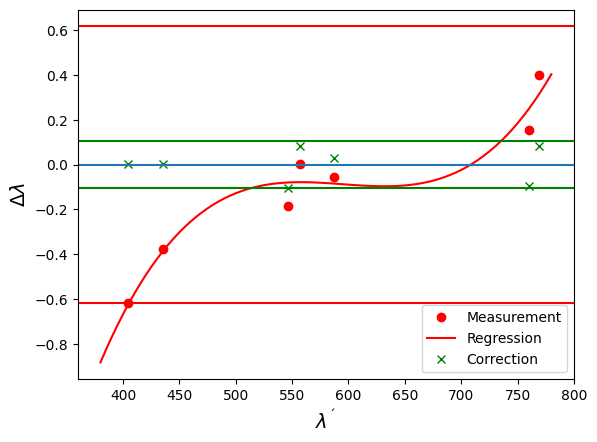

In [5]:
diff_o, qs_o, qmm_o = q_param_org(S[1], S[0])
print(diff_o, qs_o, qmm_o)
diff_r, qs_r, qmm_r = vc.q_param_corr(S[1], S[0])
print(diff_r, qs_r, qmm_r)
pyplot.plot(S[0], diff_o, 'ro', label='Measurement')
x_meas = lx.getwlr([380,780,5])
diff_poly =  vc.p_diff(x_meas)
pyplot.plot(x_meas, diff_poly, 'r-', label='Regression')
pyplot.plot(S[0], diff_r, 'gx', label='Correction')
pyplot.axhline(qmm_o, color='r')
pyplot.axhline(qmm_r, color='g')
pyplot.axhline(-qmm_o, color='r')
pyplot.axhline(-qmm_r, color='g')
pyplot.axhline(0)
pyplot.xlabel(strLambdaPrime, fontsize=label_font_size)
pyplot.ylabel('$\Delta \lambda$', fontsize=label_font_size)
pyplot.legend()
save_fig(dir=outDir, filename='LambdaDiff')

## MC

In [6]:
verbosity = 0
trials = 10000
res_array = np.zeros((trials, seriesDomainRange.coef.shape[0]))
q_res_array = np.zeros((trials, 2))
wavelength_trials = np.zeros((trials,2, 2, Kr_sd.shape[1]))
nominal_scale = lx.getwlr([380,780,5])
n_lambda=nominal_scale.shape[0]
wavelength_scale = np.zeros((trials, n_lambda))
max_Hg = np.max(Hg_sd[1])
max_Kr = np.max(Kr_sd[1])
for i in range(trials):
    wavelength_trials[i][0][0] = Hg_sd[0]
    wavelength_trials[i][1][0] = Kr_sd[0]
    if i > 0:
        wavelength_trials[i][0][1] = Hg_sd[1]+ draw_values_gum(0, max_Hg*0.01, draws=Hg_sd.shape[1], distribution='normal')
        wavelength_trials[i][1][1]= Kr_sd[1]+ draw_values_gum(0, max_Kr*0.001, draws=Kr_sd.shape[1], distribution='normal')
    else:
        wavelength_trials[i][0][1] = Hg_sd[1]
        wavelength_trials[i][1][1] = Kr_sd[1]
    S = np.hstack((calib_Hg.getPairs(wavelength_trials[i][0], verbosity=verbosity), calib_Kr.getPairs(wavelength_trials[i][1], verbosity=verbosity)))
    vc = ValueCorrection(n=3, domain=None)
    seriesDomainRange = vc.fit(S[1], S[0], domain=[380,780])
    res_array[i]=seriesDomainRange.coef
    x_meas, x_ref = vc.getInputValues()
    _, qs_r, qmm_r = vc.q_param_corr(x_meas, x_ref)
    q_res_array[i][0] = qs_r
    q_res_array[i][1] = qmm_r
    wavelength_scale[i]=vc.p(nominal_scale)
print( 'Mean:', np.mean(res_array, axis=0))
print( 'StdDev:', np.std(res_array, axis=0))
print( 'Rel.StdDev:', np.std(res_array, axis=0)/np.mean(res_array, axis=0))

Mean: [5.7990e+02 1.9992e+02 -1.4371e-01 7.2885e-01]
StdDev: [6.8743e-02 2.8079e-01 6.9801e-02 3.6243e-01]
Rel.StdDev: [1.1854e-04 1.4045e-03 -4.8570e-01 4.9726e-01]


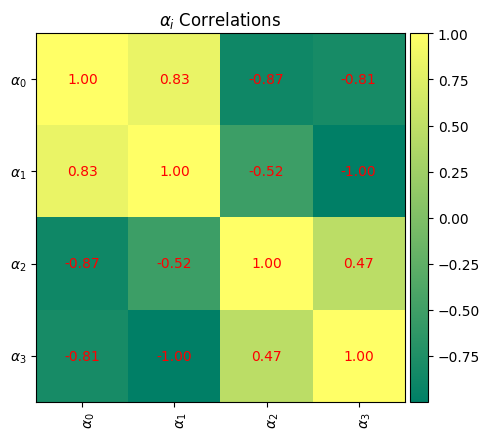

In [7]:
x_label_list = [r'$\alpha_{0}$', r'$\alpha_{1}$', r'$\alpha_{2}$', r'$\alpha_{3}$']
corr = np.corrcoef(res_array.T)
plotCorrMatrixSmall(corr, x_label_list, title=r'$\alpha_{i}$ Correlations', fileName=None, with_values=True)
save_fig(dir=outDir, filename='WavelengthCorr')


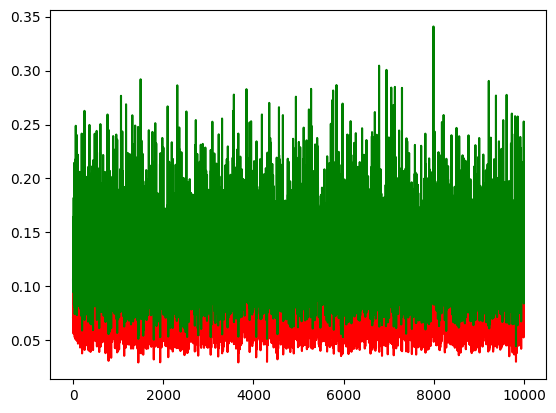

In [8]:
pyplot.plot(q_res_array[:, 0], 'r')
pyplot.plot(q_res_array[:, 1], 'g')

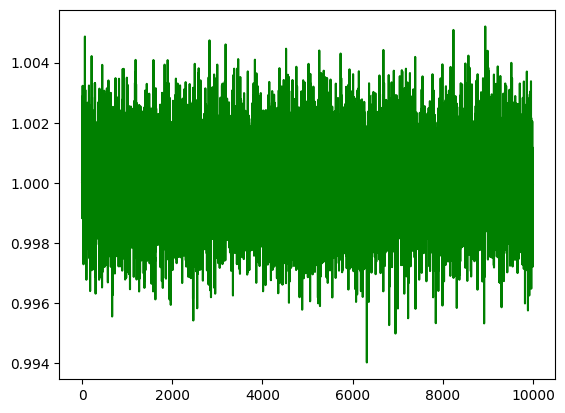

In [9]:
def data_scale( data, version = 'rel'):
    return data/np.mean(data)
pyplot.plot(data_scale(res_array[:, 0]), 'r')
pyplot.plot(data_scale(res_array[:, 1]), 'g')

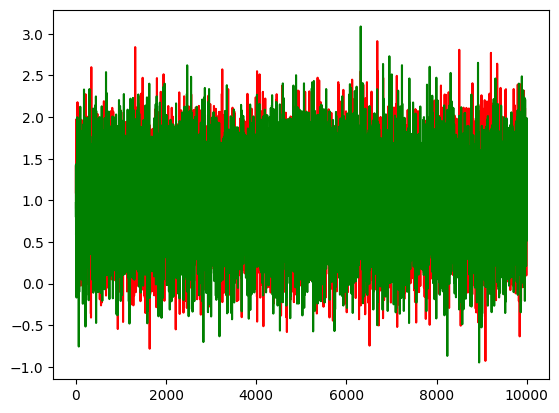

In [10]:
pyplot.plot(data_scale(res_array[:, 2]), 'r')
pyplot.plot(data_scale(res_array[:, 3]), 'g')

In [11]:
from empir19nrm02.tools import plotHist, plotYxy, confidence_ellipse, plotCorrMatrixSmall
from empir19nrm02.tools.help import get_target, label_font_size, save_fig


def f1prime_fromscale( w_scale:ndarray, nom_scale = None, verbosity = 1)->ndarray:
    f1prime_results = np.zeros(w_scale.shape[0])
    if nom_scale is None:
        nom_scale = lx.getwlr([380,780,5])
    sd = get_target(cieobs='1931_2', target_index=2, wl_new= nom_scale)
    for i in range(w_scale.shape[0]):
        sd_trial = np.vstack((w_scale[i], sd[1]))
        f1prime_results[i]=lx.spectral_mismatch_and_uncertainty.f1prime(sd_trial, S_C='A', cieobs='1931_2', s_target_index=2)
    if verbosity:
        plotHist(f1prime_results)
    return f1prime_results

# THX: https://stackoverflow.com/questions/7965743/how-can-i-set-the-aspect-ratio-in-matplotlib
def aspectratio_to_one( ax):
    ratio = 1.0
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

def plot_xye(Yxy_data, name='None', color = 'r', ax1 = None):
    if ax1 is None:
        fig, ax1 = pyplot.subplots()
    ax1.plot(Yxy_data[:,1],Yxy_data[:,2], color+'x' , label = name)
    ax1.plot(np.mean(Yxy_data[:,1]),np.mean(Yxy_data[:,2]), 'ko')
    e=confidence_ellipse(Yxy_data[:,1],Yxy_data[:,2], ax1, n_std=2.45, edgecolor='k')
    ax1.legend()
    ax1.grid(b=True)
    aspectratio_to_one(ax1)
    print(name)
    print(e)
    print( 'std_x, std_y, corr:', np.std(Yxy_data[:,1]), np.std(Yxy_data[:,2]), np.corrcoef(Yxy_data[:,1], Yxy_data[:,2]))
    return ax1

def Yxy_fromscale( w_scale:ndarray, nom_scale = None, verbosity = 1, ax1=None, color='r',name=None)->ndarray:
    Yxy_results = np.zeros((w_scale.shape[0],3))
    if nom_scale is None:
        nom_scale = lx.getwlr([380,780,5])
    sd_L41_org = lx._CIE_ILLUMINANTS['LED_L41']
    sd_L41 = lx.cie_interp(sd_L41_org, nom_scale, kind='linear')
    for i in range(w_scale.shape[0]):
        sd_trial = np.vstack((w_scale[i], sd_L41[1]))
        XYZ = lx.spd_to_xyz( sd_trial, relative=False, cieobs='1931_2')
        Yxy = lx.xyz_to_Yxy(XYZ)
        Yxy_results[i]=Yxy
    if verbosity:
        ax1=plot_xye(Yxy_results, ax1=ax1, color=color, name=name)
    return Yxy_results, ax1


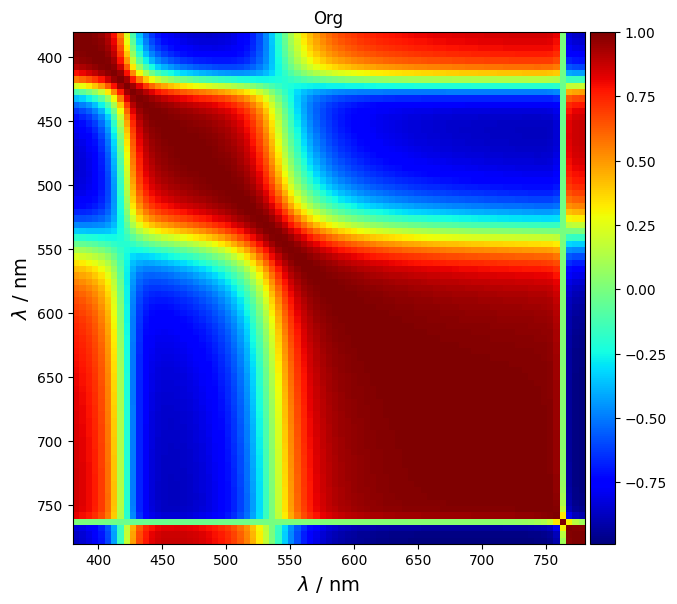

In [12]:

from empir19nrm02.tools.help import plotCorrelation
cov_data = np.corrcoef(wavelength_scale.T)
plotCorrelation(cov_data, nominal_scale, 'Org')
save_fig(dir=outDir, filename='Corr_Org')


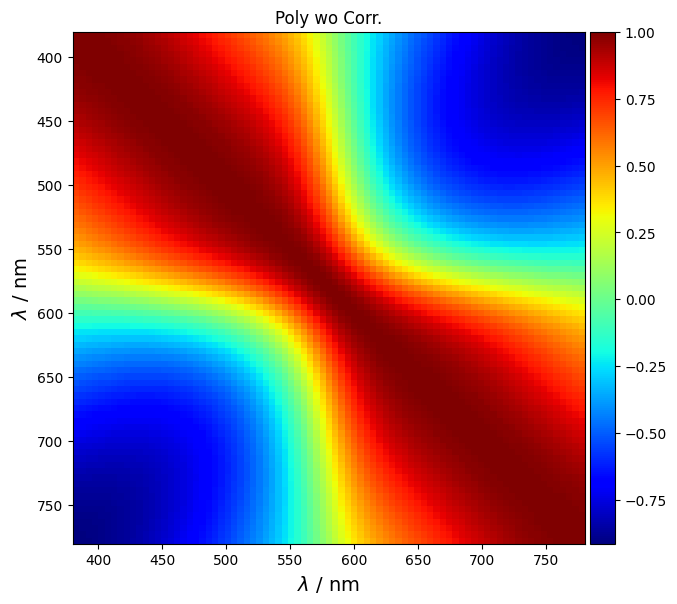

In [13]:
mean_wc = np.mean(res_array, axis=0)
std_wc = np.std(res_array, axis=0)
wavelength_scale2 = np.zeros((trials, n_lambda))
poly_scale2 = draw_values_gum( mean_wc, std_wc, draws=trials, distribution='normal').T
for i in range (trials):
    p = Polynomial(poly_scale2[i], domain=[380,780])
    wavelength_scale2[i]=p(nominal_scale)

cov_data2 = np.corrcoef(wavelength_scale2.T)
plotCorrelation(cov_data2, nominal_scale, 'Poly wo Corr.')
save_fig(dir=outDir, filename='Poly_wo_Corr')


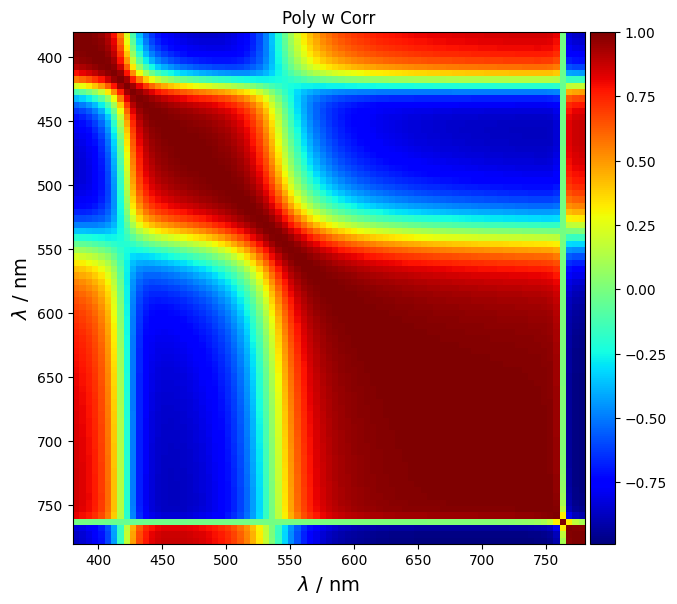

In [14]:
cov_wc = np.cov(res_array.T)
wavelength_scale3 = np.zeros((trials, n_lambda))
poly_scale3 = np.random.default_rng().multivariate_normal(mean_wc, cov_wc, trials)
for i in range (trials):
    p = Polynomial(poly_scale3[i], domain=[380,780])
    wavelength_scale3[i]=p(nominal_scale)

cov_data3 = np.corrcoef(wavelength_scale3.T)
plotCorrelation(cov_data3, nominal_scale, 'Poly w Corr')
save_fig(dir=outDir, filename='Poly_w_Corr')



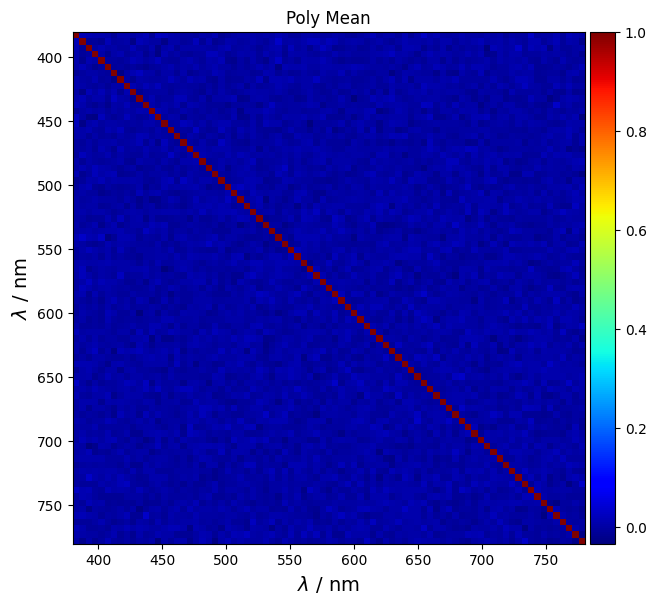

In [15]:
wavelength_scale4 = np.zeros((trials, n_lambda))
p = Polynomial(mean_wc, domain=[380,780])
std_wc_kessel = qmm_r
wl_noise = np.zeros((nominal_scale.shape[0]))
wl_noise[:]=std_wc_kessel
current_scale = draw_values_gum(nominal_scale, wl_noise, draws=trials).T
for i in range (trials):
    wavelength_scale4[i]=p(current_scale[i])
cov_data4 = np.corrcoef(wavelength_scale4.T)
plotCorrelation(cov_data4, nominal_scale, 'Poly Mean')
save_fig(dir=outDir, filename='Poly_Mean')


mean: [2.6751e-03 2.7752e-03 2.6787e-03 2.9468e-03]
std: [8.6780e-04 1.2012e-03 8.8996e-04 3.5175e-04]


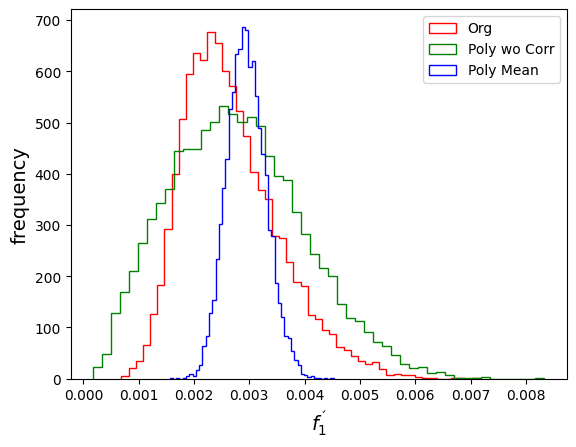

In [16]:
f1p_results = np.zeros((4,trials))
f1p_results[0] = f1prime_fromscale(wavelength_scale, verbosity=0)
f1p_results[1] = f1prime_fromscale(wavelength_scale2, verbosity=0)
f1p_results[2] = f1prime_fromscale(wavelength_scale3, verbosity=0)
f1p_results[3] = f1prime_fromscale(wavelength_scale4, verbosity=0)

print('mean:', np.mean(f1p_results, axis = 1))
print('std:', np.std(f1p_results, axis = 1))
#plotHist(f1p_results, xLabel=strf1p, yLabel='frequency')

pyplot.hist(f1p_results[0], histtype='step', bins=50, label='Org', color='r')
pyplot.hist(f1p_results[1], histtype='step', bins=50, label='Poly wo Corr', color='g')
pyplot.hist(f1p_results[3], histtype='step', bins=50, label='Poly Mean', color='b')
pyplot.xlabel(strf1p, fontsize=label_font_size)
pyplot.ylabel(r'frequency',fontsize=label_font_size)
pyplot.legend()
save_fig(dir=outDir, filename='f1prime_Hist')


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

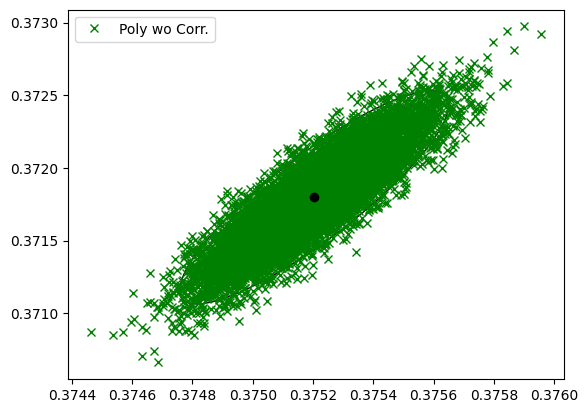

In [17]:
Yxy_resutls, ax1 = Yxy_fromscale(wavelength_scale2, name='Poly wo Corr.', color = 'g', verbosity=1)
Yxy_resutls, ax1 = Yxy_fromscale(wavelength_scale4, name='Poly Mean', ax1=ax1, color='b', verbosity=1)
Yxy_resutls, ax1 = Yxy_fromscale(wavelength_scale, name = 'Org', ax1=ax1, color='r', verbosity=1)
pyplot.xlabel('x', fontsize=label_font_size)
pyplot.ylabel('y',fontsize=label_font_size)
save_fig(dir=outDir, filename='Yxy_plot')



# Non-linearity correction


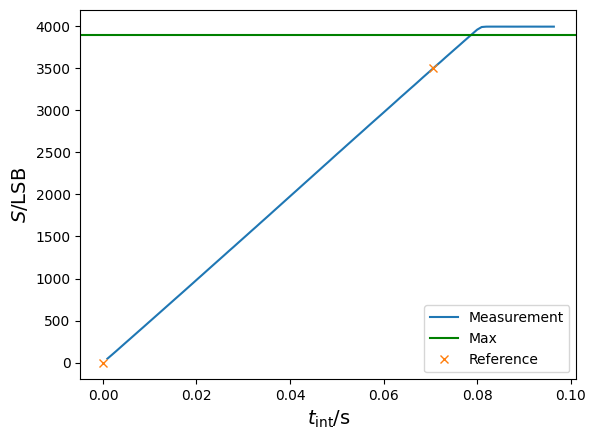

In [18]:
nonlin_sd = lx.utils.getdata('..\\data\\SPD\\' + 'nl_sample.csv', sep=';', kind='np').transpose()

pyplot.plot( nonlin_sd[0], nonlin_sd[1], label='Measurement')
pyplot.xlabel(r'$t_{\mathrm{int}}/\mathrm{s}$', fontsize=label_font_size)
pyplot.ylabel(r'$S/\mathrm{LSB}$', fontsize=label_font_size)
pyplot.axhline(3900, color='g', label="Max")
time_interp = scipy.interpolate.interp1d(nonlin_sd[1], nonlin_sd[0])
help = np.array(([0, time_interp( 3500.)], [0,3500]))
pyplot.plot( help[0], help[1], 'x', label="Reference")
pyplot.legend()
save_fig(dir=outDir, filename='NonLinMeasurement')

In [19]:
from empir19nrm02.tools import draw_values_gum

used_domain = [0,4000]
linFit = ValueCorrectionNonLinearity(n=3, domain=None)
lin_series = linFit.fit(nonlin_sd[1],nonlin_sd[0], domain=used_domain)
print( lin_series.coef)




[2.0042e+03 1.9861e+03 -1.5444e+00 1.6649e+01]


Standard deviation: 0.5212602365590971
Max. deviation: 1.2480792490175645


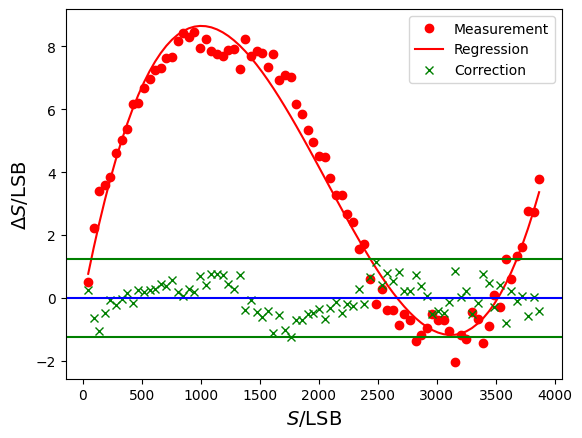

In [20]:
x_meas, x_ref = linFit.getInputValues()
x_prime_fit = x_meas
diff_values = x_ref-x_meas
diff_poly =  linFit.p_diff(x_prime_fit)
pyplot.plot( x_prime_fit, diff_values, 'ro', label='Measurement')
pyplot.plot( x_prime_fit, diff_poly, 'r-', label='Regression')
pyplot.plot( x_prime_fit, diff_poly-diff_values, 'gx', label='Correction')
diff_r, qs_r, qmm_r = linFit.q_param_corr(x_meas, x_ref)
pyplot.axhline(qmm_r, color='g')
pyplot.axhline(-qmm_r, color='g')
pyplot.axhline(0, color='b')
pyplot.ylabel(r'$\Delta S/\mathrm{LSB}$', fontsize=label_font_size)
pyplot.xlabel(r'$S/\mathrm{LSB}$', fontsize=label_font_size)
pyplot.legend()
print( 'Standard deviation:', qs_r)
print( 'Max. deviation:', qmm_r)
save_fig(dir=outDir, filename='NonLinEval')


# MC

In [21]:
res_array = np.zeros((trials, lin_series.coef.shape[0]))
q_res_array = np.zeros((trials, 2))
nonlin_trials = np.zeros((trials,nonlin_sd.shape[1]))
for i in range(trials):
    if i > 0:
        nonlin_trials[i] = nonlin_sd[1]+ draw_values_gum(0, 1, draws=nonlin_sd.shape[1], distribution='normal')
    else:
        nonlin_trials[i] = nonlin_sd[1]
    lin_series = linFit.fit(nonlin_trials[i],nonlin_sd[0], domain=used_domain)
    res_array[i]=lin_series.coef
    x_meas, x_ref = linFit.getInputValues()
    _, qs_r, qmm_r = linFit.q_param_corr(x_meas, x_ref)
    q_res_array[i][0] = qs_r
    q_res_array[i][1] = qmm_r
print( 'Mean:', np.mean(res_array, axis=0))
print( 'StdDev:', np.std(res_array, axis=0))
print( 'Rel.StdDev:', np.std(res_array, axis=0)/np.mean(res_array, axis=0))

Mean: [2.0042e+03 1.9861e+03 -1.5486e+00 1.6637e+01]
StdDev: [4.7401e-01 6.3849e-01 4.0259e-01 8.1765e-01]
Rel.StdDev: [2.3651e-04 3.2148e-04 -2.5997e-01 4.9148e-02]


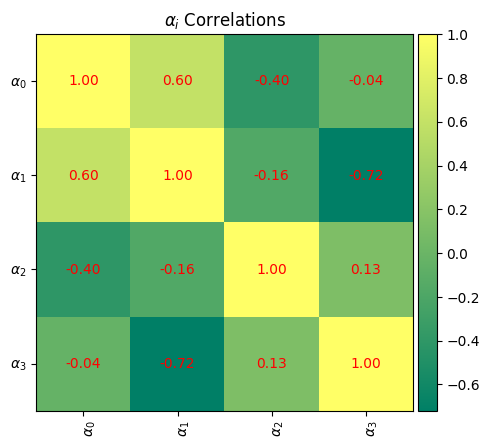

In [22]:
x_label_list = [ r'$\alpha_{0}$', r'$\alpha_{1}$', r'$\alpha_{2}$', r'$\alpha_{3}$']
corr = np.corrcoef(res_array.T)
plotCorrMatrixSmall(corr, x_label_list, title=r'$\alpha_{i}$ Correlations', fileName=None, with_values=True)
save_fig(dir=outDir, filename='NonLinCorr')


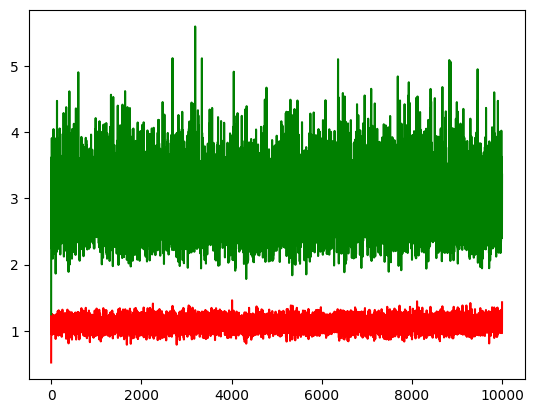

In [23]:
pyplot.plot(q_res_array[:,0], 'r')
pyplot.plot(q_res_array[:,1], 'g')

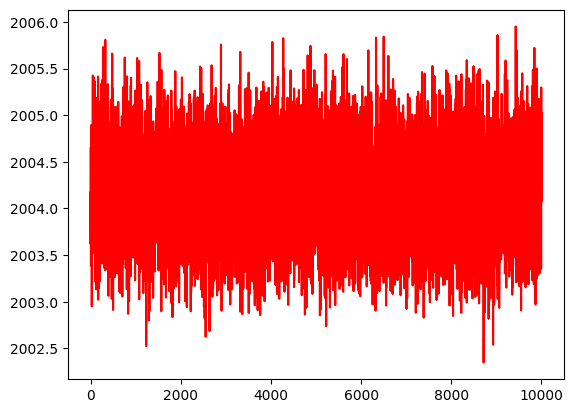

In [24]:
pyplot.plot(res_array[:,0], 'r')